# Bareinboim Inequalities for MIMIC

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.stats import rankdata

exportdir='/data/localhost/taufiq/export-dir/'

In [2]:
import logging
logging.basicConfig(filename='bb-bounds.log', level=logging.INFO)

In [3]:
nra = 5
nr_reps = 1
col_bins_num = 5

In [51]:
MIMICtable = pd.read_csv(exportdir + '/MIMIC-1hourly-length-5-filtered.csv')
MIMIC_generated_males = pd.read_csv(exportdir + '/MIMIC-generated-length-5-gender-0.0.csv')
MIMIC_generated_females = pd.read_csv(exportdir + '/MIMIC-generated-length-5-gender-1.0.csv')
MIMICtable = pd.concat([MIMICtable, MIMIC_generated_males, MIMIC_generated_females], ignore_index=True)

In [52]:
age_ranked = rankdata(MIMICtable['age'])/len(MIMICtable)
age_bins = np.floor((age_ranked + 0.2499999999)*4)
median_ages = [MIMICtable.loc[age_bins==1, 'age'].median(), MIMICtable.loc[age_bins==2, 'age'].median(), MIMICtable.loc[age_bins==3, 'age'].median(), MIMICtable.loc[age_bins==4, 'age'].median()]
MIMICtable = MIMICtable.rename(columns={"age": "age_raw"})
MIMICtable['age'] = age_bins

In [26]:
import os
import glob
os.chdir("/data/localhost/taufiq/pulse-data-5-step")
extension = 'final_.csv'
all_filenames = [i for i in glob.glob('*{}'.format(extension))]
all_filenames = all_filenames + [i for i in glob.glob('./synthetic_data/*{}'.format(extension))]
pulse_data = pd.concat([pd.read_csv(f) for f in all_filenames ])
pulse_data = pulse_data.rename(columns={'id': 'icustay_id'})
pulse_data['icustay_id'] = pulse_data['icustay_id'].astype(int)
pulse_data = pulse_data.reset_index(drop=True)
pulse_data = pulse_data.sort_values(by=['icustay_id', 'SimulationTime(s)'], ignore_index=True)
pulse_data['bloc'] = np.arange(len(pulse_data))%5 + 1
pulse_data.head()

,Albumin - BloodConcentration (mg/L),ArterialCarbonDioxidePressure (mmHg),ArterialOxygenPressure (mmHg),ArterialPressure (mmHg),Bicarbonate - BloodConcentration (mg/L),BloodPH (None),BloodUreaNitrogenConcentration (mg/dL),BloodVolume (mL),Calcium - BloodConcentration (mg/L),CarbonDioxideSaturation (None),...,RespirationRate (1/min),SaturationAndFractionOfInspiredOxygenRatio (None),SimulationTime(s),SkinTemperature (degC),Sodium - BloodConcentration (mg/L),SystolicArterialPressure (mmHg),WhiteBloodCellCount (ct/uL),icustay_id,time,bloc
0,36971.911153,40.121759,90.942581,88.417880,1590.189288,7.412477,13.036798,4640.620191,48.207067,0.028632,...,20.134228,4.646044,0.0,33.130515,3327.522356,119.898164,7000.0,3,7.245400e+09,1
1,35899.080416,40.295497,92.240242,92.028320,1590.361120,7.410769,15.109420,4769.504190,54.298146,0.028445,...,20.833333,4.645351,3600.0,32.814843,3316.814960,121.301612,7000.0,3,7.245403e+09,2
2,34887.421594,40.313523,92.215037,106.015304,1590.284502,7.410592,20.730085,4897.953845,60.775848,0.028452,...,20.833333,4.645612,7200.0,32.533793,3307.756345,123.275558,7000.0,3,7.245407e+09,3
3,33927.979505,40.325572,92.262822,103.367986,1590.257833,7.410474,25.855462,5026.549368,66.898886,0.028449,...,20.833333,4.645723,10800.0,32.765652,3302.748443,125.600846,7000.0,3,7.245410e+09,4
4,33088.536551,40.305062,92.327881,71.410965,1589.972682,7.410675,30.823689,5144.112833,72.855658,0.028455,...,20.833333,4.646063,14400.0,32.834440,3277.230920,126.459716,7000.0,3,7.245414e+09,5


In [29]:
len(pulse_data)/5

14610.0

In [60]:
column_mappings = {
    'Albumin - BloodConcentration (mg/L)': 'Albumin',
    'ArterialCarbonDioxidePressure (mmHg)': 'paCO2',
    'ArterialOxygenPressure (mmHg)': 'paO2',
    'Bicarbonate - BloodConcentration (mg/L)': 'HCO3',
    'BloodPH (None)': 'Arterial_pH',
    'Calcium - BloodConcentration (mg/L)': 'Calcium',
    'Chloride - BloodConcentration (mg/L)': 'Chloride',
    'Creatinine - BloodConcentration (mg/L)': 'Creatinine',
    'DiastolicArterialPressure (mmHg)': 'DiaBP',
    'Glucose - BloodConcentration (mg/L)': 'Glucose',
    'Lactate - BloodConcentration (mg/L)': 'Arterial_lactate',
    'MeanArterialPressure (mmHg)': 'MeanBP',
    'Potassium - BloodConcentration (mg/L)': 'Potassium',
    'RespirationRate (1/min)': 'RR',
    'SkinTemperature (degC)': 'Temp_C',
    'Sodium - BloodConcentration (mg/L)': 'Sodium',
    'SystolicArterialPressure (mmHg)': 'SysBP',
    'WhiteBloodCellCount (ct/uL)': 'WBC_count',
    'HeartRate (1/min)': 'HR'
}

pulse_rename = {}

for k, v in column_mappings.items():
    pulse_rename.update({k: f"{v}"})

sim_data = pulse_data.rename(columns=pulse_rename)

sim_data = sim_data.merge(MIMICtable[['gender', 'age', 'Weight_kg', 'icustay_id', 'bloc']], left_on=['icustay_id', 'bloc'], right_on=['icustay_id', 'bloc'])

sim_data.head()

,Albumin,paCO2,paO2,ArterialPressure (mmHg),HCO3,Arterial_pH,BloodUreaNitrogenConcentration (mg/dL),BloodVolume (mL),Calcium,CarbonDioxideSaturation (None),...,Temp_C,Sodium,SysBP,WBC_count,icustay_id,time,bloc,gender,age,Weight_kg
0,36956.148921,38.963593,91.699266,109.970415,1588.920899,7.424054,13.099385,5142.230283,48.184907,0.029009,...,33.112334,3325.983809,115.313637,7000.0,14,4.264269e+09,1,0.0,4.0,73.300003
1,35393.986455,39.348167,92.657544,115.301997,1589.009926,7.420172,15.401907,5358.294397,52.868259,0.028744,...,32.445347,3315.232842,117.565700,7000.0,14,4.264273e+09,2,0.0,4.0,71.800000
2,28799.488674,39.204086,92.999155,55.596113,1588.457784,7.421622,17.884865,6573.488118,48.969245,0.028816,...,32.653264,3306.962520,135.506687,7000.0,14,4.264276e+09,3,0.0,4.0,71.800000
3,28137.774189,39.340030,93.043224,131.119564,1588.152799,7.420254,22.939166,6717.344511,53.651599,0.028764,...,33.029873,3307.121266,138.081243,7000.0,14,4.264280e+09,4,0.0,4.0,71.800000
4,27762.117998,39.349305,93.040334,124.141909,1588.063797,7.420161,27.589372,6797.503106,58.658890,0.028759,...,32.982227,3281.155130,134.524102,7000.0,14,4.264284e+09,5,0.0,4.0,71.800000


In [8]:
from ast import literal_eval


def find_elements(series, element):
    return series.apply(lambda x: literal_eval(str(x)) == element)

def find_elements_starting_with(series, element):
    return series.apply(lambda x: literal_eval(str(x))[:len(element)] == element)

def find_elements_containing(series, element):
    return series.apply(lambda x: literal_eval(str(element)) in literal_eval(str(x)))

In [9]:
def compute_probs(trajec_actions, x_trajec, gender, age, actions):
    prob_a_den = 0
    gamma = []
    df = pd.DataFrame()
    df[[f'x_0',f'x_1',f'x_2',f'x_3']] = pd.DataFrame(trajec_actions['x_t'].tolist(), index= trajec_actions.index)
    df[[f'a_0',f'a_1',f'a_2',f'a_3']] = pd.DataFrame(trajec_actions['actions'].tolist(), index= trajec_actions.index)
    trajecs_filtered = (trajec_actions['gender'] == gender) & (trajec_actions['age'] == age)
    num_term = trajecs_filtered
    den_term_1 = trajecs_filtered
    den_term_2 = trajecs_filtered
    for i in range(len(actions)):
        num_term = num_term & (df[f'x_{i}'] == x_trajec[i]) & (df[f'a_{i}'] == actions[i])
        prob_a_num = num_term.sum()
        if i == 0:
            den_term_1 = den_term_1 & (df[f'x_{i}'] == x_trajec[i])
            prob_a_den += den_term_1.sum()
        else:
            den_term_1 = den_term_1 & (df[f'x_{i}'] == x_trajec[i]) & (df[f'a_{i-1}'] == actions[i-1])
            den_term_2 = den_term_2 & (df[f'x_{i-1}'] == x_trajec[i-1]) & (df[f'a_{i-1}'] == actions[i-1])
            prob_a_den += den_term_1.sum() - den_term_2.sum()
        if prob_a_num == 0:
            gamma.append(0)
        else:
            gamma.append(prob_a_num/prob_a_den)
    return gamma

In [70]:
from sklearn.utils import resample
def bootstrap_distribution_(col, gender, age, action, x_trajec, trajec_actions, sim_trajec_actions, sim_data, MIMICtable, n_iter=100, i=3):
    sim = sim_trajec_actions[['actions', 'gender', 'age', 'icustay_id', 'x_t']].merge(sim_data[sim_data['bloc'] == i+2], left_on=['icustay_id', 'gender', 'age'], right_on=['icustay_id', 'gender', 'age'])
    obs_data = trajec_actions[['actions', 'gender', 'age', 'icustay_id', 'x_t']].merge(MIMICtable[MIMICtable['bloc'] == i+2], left_on=['icustay_id', 'gender', 'age'], right_on=['icustay_id', 'gender', 'age'])
    sim.loc[:,f'x_tuple'] = sim['x_t'].apply(tuple)
    sim.loc[:,f'actions_tuple'] = sim['actions'].apply(tuple)
    obs_data.loc[:,f'x_tuple'] = obs_data['x_t'].apply(tuple)
    obs_data.loc[:,f'actions_tuple'] = obs_data['actions'].apply(tuple)
    df = pd.DataFrame()
    max_y = obs_data.loc[(obs_data['gender'] == gender) & (obs_data['age'] == age) & (obs_data['x_t'].apply(lambda x: x[-1]) == x_trajec[-1]), col].max()
    min_y = obs_data.loc[(obs_data['gender'] == gender) & (obs_data['age'] == age) & (obs_data['x_t'].apply(lambda x: x[-1]) == x_trajec[-1]), col].min()
    sim_filtered = sim[(sim['gender'] == gender) & (sim['age'] == age) & (sim[f'x_tuple']==tuple(x_trajec)) & (sim['actions_tuple'] == tuple(action))].copy()
    real_filtered = obs_data[(obs_data['gender'] == gender) & (obs_data['age'] == age) & (obs_data[f'x_tuple']==tuple(x_trajec)) & (obs_data['actions_tuple'] == tuple(action))].copy()
    if len(real_filtered) > 1 and len(sim_filtered) > 1:
        for j in range(n_iter):
            obs_resampled = resample(obs_data, n_samples=len(obs_data))
            probs = compute_probs(obs_resampled, x_trajec, gender, age, action)
            prob = probs[i]
            real_train = resample(real_filtered, n_samples=len(real_filtered))
            exp_y = real_train[col].mean()
            sim_train = resample(sim_filtered, n_samples=len(sim_filtered))
            exp_y_sim = sim_train[col].mean()
            df = df.append({'Exp_y': exp_y, 'UB': prob*exp_y + (1-prob)*max_y, 'LB': prob*exp_y + (1-prob)*min_y, 'Sim_exp_y': exp_y_sim, 'max_y':max_y, 'min_y': min_y}, ignore_index=True)
        return df
    return None

In [11]:
import matplotlib.pyplot as plt
def plot_bootstrapp_distributions(col, gender, age, action, column_v):
    global trajec_actions, pulse_trajec_actions
    df = bootstrap_distribution_(col, gender, age, action, column_v, trajec_actions, pulse_trajec_actions)
    plt.hist(df['Exp_y'], bins=10, color='grey', label='Exp(y)')
    ub_lim = df['UB'].mean() + 1.96*df['UB'].std()
    lb_lim = df['LB'].mean() - 1.96*df['LB'].std()
    plt.axvspan(lb_lim, ub_lim, alpha=0.1, color='purple')
    plt.hist(df['Sim_exp_y'], bins=10, color='pink', label='Simulated Exp(y)')
    plt.legend()
    plt.show()

In [12]:
import matplotlib.pyplot as plt

column_names_unit = {
    'Albumin': 'Albumin Blood Concentration (mg/L)',
#     'paCO2': 'Arterial $CO_2$ Pressure (mmHg)',
#     'paO2': 'Arterial $O_2$ Pressure (mmHg)',
#     'HCO3': 'Bicarbonate Blood Concentration (mg/L)',
    'Arterial_pH': 'Arterial pH',
    'Arterial_lactate': 'Lactate Blood Concentration (mg/L)',
    'Calcium': 'Calcium Blood Concentration (mg/L)',
    'Chloride': 'Chloride Blood Concentration (mg/L)',
    'Creatinine': 'Creatinine Blood Concentration (mg/L)',
    'DiaBP': 'Diastolic Arterial Pressure (mmHg)',
    'SysBP': 'Systolic Arterial Pressure (mmHg)',
    'Glucose': 'Glucose Blood Concentration (mg/L)',
    'MeanBP': 'Mean Arterial Pressure (mmHg)',
    'Potassium': 'Potassium Blood Concentration (mg/L)',
    'RR': 'Respiration Rate (1/min)',
    'Temp_C': 'Skin Temperature (C)',
    'Sodium': 'Sodium Blood Concentration (mg/L)',
    'WBC_count': 'White Blood Cell Count (ct/uL)',
    'HR': 'Heart Rate (1/min)'
}

In [13]:
column_names_dict = {
    'Albumin': 'Albumin Blood Concentration',
    'paCO2': 'Arterial $CO_2$ Pressure',
    'paO2': 'Arterial $O_2$ Pressure',
    'HCO3': 'Bicarbonate Blood Concentration',
    'Arterial_pH': 'Arterial pH',
    'Arterial_lactate': 'Lactate Blood Concentration',
    'Calcium': 'Calcium Blood Concentration',
    'Chloride': 'Chloride Blood Concentration',
    'Creatinine': 'Creatinine Blood Concentration',
    'DiaBP': 'Diastolic Arterial Pressure',
    'SysBP': 'Systolic Arterial Pressure',
    'Glucose': 'Glucose Blood Concentration',
    'MeanBP': 'Mean Arterial Pressure',
    'Potassium': 'Potassium Blood Concentration',
    'RR': 'Respiration Rate',
    'Temp_C': 'Skin Temperature',
    'Sodium': 'Sodium Blood Concentration',
    'WBC_count': 'White Blood Cell Count',
    'HR': 'Heart Rate'
}

In [72]:
def plot_bounds_bootstrap(col, gender, age, action, column_v):
#     global trajec_actions, pulse_trajec_actions, column_names_unit
    trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions.csv", converters={'actions': eval, 'x_t': eval})
    sim_trajec_actions = pd.read_csv(f"{hyp_test_dir}/sim_trajec_actions.csv", converters={'actions': eval, 'x_t':eval})
    lb = []
    ub = []
    sim_mean, sim_lb, sim_ub = [], [], []
    max_vals, min_vals = [], []
    probs = []
    for i in range(len(action)):
        df = bootstrap_distribution_(col, gender, age, action, column_v, trajec_actions, sim_trajec_actions, sim_data, MIMICtable, n_iter=100, i=i)
        lb.append(df['LB'].mean() - 1.96*df['LB'].std())
        ub.append(df['UB'].mean() + 1.96*df['UB'].std())
        sim_ub.append(df['Sim_exp_y'].mean() + 1.96*df['Sim_exp_y'].std())
        sim_lb.append(df['Sim_exp_y'].mean() - 1.96*df['Sim_exp_y'].std())
        sim_mean.append(df['Sim_exp_y'].mean())
        max_vals.append(df['max_y'].max())
        min_vals.append(df['min_y'].min())
    plt.figure(figsize=(12,8)),
    plt.plot(range(1,5), sim_mean, '-', color='gray')
    plt.xlabel('Time (hr)', fontsize=13)
    plt.ylabel(column_names_unit[col], fontsize=13)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.fill_between(range(1,5), sim_ub, sim_lb, color='navy', alpha=0.4, label='Simulated')
    plt.fill_between(range(1,5), lb, ub, color='purple', alpha=0.4, label='Bareinboim bounds')
    plt.fill_between(range(1,5), min_vals, max_vals, color='pink', alpha=0.5, label='Max-min bounds')
    plt.legend(fontsize=13)
    plt.grid(True)
    plt.show()

In [15]:
def rejected_hypotheses_bootstrap_trajectories(col, trajec_actions, sim_trajec_actions, sim_data, MIMICtable):
    T = 4
    state_actions = trajec_actions[['gender', 'age', 'actions', col]].copy()
    state_actions.loc[:,'a'] = state_actions['actions'].apply(tuple)
    state_actions.loc[:,'s'] = state_actions[col].apply(tuple)
    state_actions = state_actions.drop_duplicates(['gender', 'age', 'a', 's'])
    total_hypotheses = len(state_actions)
    p_values = pd.DataFrame()
    for index, row in state_actions.iterrows():
        logging.info(f"On index {index}/{total_hypotheses}")
        p = 1
        p_ub, p_lb = [], []
        for t in range(T):
            df = bootstrap_distribution_(col, row['gender'], row['age'], row['actions'], row[col], trajec_actions, sim_trajec_actions, n_iter=100, i=t)
            if df is not None:
                sigma_ub = (df['UB']-df['Sim_exp_y']).var()
                exp_ub = (df['UB']-df['Sim_exp_y']).mean()
                p_ub.append(st.norm.cdf(exp_ub/np.sqrt(sigma_ub)))
                sigma_lb = (df['Sim_exp_y']-df['LB']).var()
                exp_lb = (df['Sim_exp_y']-df['LB']).mean()
                p_lb.append(st.norm.cdf(exp_lb/np.sqrt(sigma_lb)))
                p = min(p, p_ub[-1] + p_lb[-1] - 1)
        if df is not None:
            p_values = p_values.append({'gender': row['gender'], 'age': row['age'], 'actions': row['actions'], col: row[col], 'p': p, 'p_lb': p_lb, 'p_ub': p_ub}, ignore_index=True)
    rej_hyps = p_values[(p_values['p']<0.05/total_hypotheses/T)].copy()
    for index, row in rej_hyps.iterrows():
        rej_hyps.loc[index, 'n_real'] = (find_elements(trajec_actions['gender'], row['gender']) & find_elements(trajec_actions['age'], row['age']) & find_elements(trajec_actions['actions'], row['actions']) & find_elements(trajec_actions[col], row[col])).sum()
        rej_hyps.loc[index, 'n_sim'] = (find_elements(sim_trajec_actions['gender'], row['gender']) & find_elements(sim_trajec_actions['age'], row['age']) & find_elements(sim_trajec_actions['actions'], row['actions']) & find_elements(sim_trajec_actions[col], row[col])).sum()
    return len(rej_hyps), p_values, rej_hyps

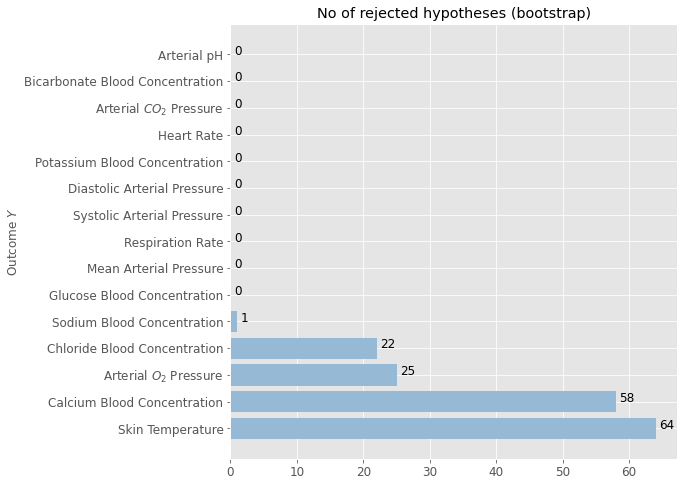

In [17]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

# hyp_test_dir = "/data/localhost/taufiq/discretization-updated/pulse_trajecs_semi_synth_data/"
hyp_test_dir = "/data/localhost/taufiq/bootstrap_kmeans/pulse_4_bins/"

rejected_hyp_bootstrap = pd.read_csv(f"{hyp_test_dir}/rej_hyp_nums.csv")
for index, row in rejected_hyp_bootstrap.iterrows():
    rejected_hyp_bootstrap.at[index, 'Outcome Y'] = column_names_dict[row['Outcome Y']]

fig, ax = plt.subplots(figsize=(8,8))

rejected_hyp_bootstrap.sort_values('# rejected hypotheses', ascending=False, inplace=True)
ax.barh(rejected_hyp_bootstrap['Outcome Y'],rejected_hyp_bootstrap['# rejected hypotheses'],  color='#96b9d6')
y = rejected_hyp_bootstrap['# rejected hypotheses']
for i, v in enumerate(y):
    ax.text(v + 0.5, i, str(v), fontsize=12)

plt.title('No of rejected hypotheses (bootstrap)')
plt.ylabel('Outcome $Y$')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.style.use('ggplot')
# plt.xlim([0,50])
plt.show()

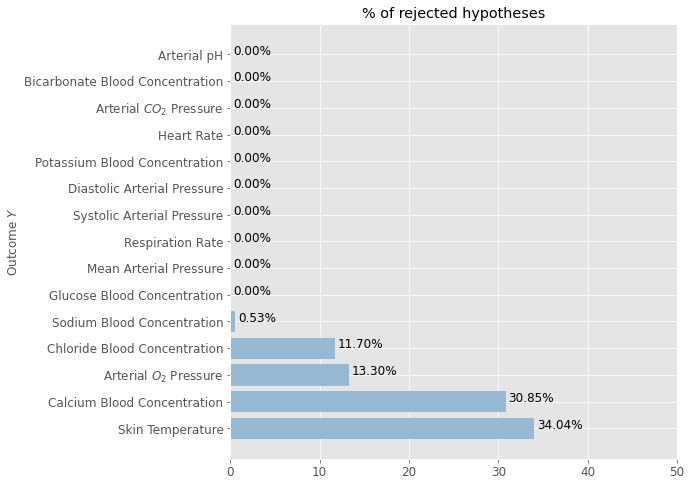

In [19]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))

rejected_hyp_bootstrap.sort_values('# rejected hypotheses', ascending=False, inplace=True)
ax.barh(rejected_hyp_bootstrap['Outcome Y'],rejected_hyp_bootstrap['# rejected hypotheses']/rejected_hyp_bootstrap['Total # hypotheses']*100,  color='#96b9d6')
y = rejected_hyp_bootstrap['# rejected hypotheses']/rejected_hyp_bootstrap['Total # hypotheses']*100
for i, v in enumerate(y):
    ax.text(v + 0.3, i, "{:.2f}%".format(v), fontsize=12)

plt.title('% of rejected hypotheses')
plt.ylabel('Outcome $Y$')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.style.use('ggplot')
plt.xlim([0,50])
plt.show()

In [21]:
col_name = "Calcium"
p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col_name}.csv", converters={'actions': eval, 'x_t': eval})
rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col_name}.csv", converters={'actions': eval, 'x_t': eval})
trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions.csv", converters={'actions': eval, 'x_t': eval})
pulse_trajec_actions = pd.read_csv(f"{hyp_test_dir}/sim_trajec_actions.csv", converters={'actions': eval, 'x_t': eval})


In [23]:
rej_hyps.head()

,Unnamed: 0,actions,age,gender,p,x_t,n_real,n_sim
0,0,"[3.0, 3.0, 3.0, 3.0]",2.0,0.0,0.0,"[3, 3, 3, 3]",135.0,147.0
1,3,"[3.0, 3.0, 3.0, 3.0]",4.0,0.0,0.0,"[2, 2, 2, 2]",135.0,200.0
2,5,"[3.0, 3.0, 3.0, 3.0]",3.0,0.0,0.0,"[1, 1, 1, 1]",47.0,6.0
3,6,"[2.0, 2.0, 2.0, 2.0]",1.0,0.0,0.0,"[3, 3, 3, 3]",31.0,12.0
4,7,"[3.0, 3.0, 3.0, 3.0]",4.0,1.0,0.0,"[1, 1, 1, 1]",42.0,2.0


In [74]:
p_values

,Unnamed: 0,actions,age,gender,p,x_t,n_real,n_sim
0,0,"[3.0, 3.0, 3.0, 3.0]",2.0,0.0,0.00,"[3, 3, 3, 3]",135.0,147.0
1,1,"[5.0, 5.0, 5.0, 5.0]",2.0,0.0,1.00,"[3, 3, 3, 3]",10.0,12.0
2,2,"[2.0, 2.0, 2.0, 2.0]",2.0,0.0,1.00,"[3, 3, 3, 3]",21.0,5.0
3,3,"[3.0, 3.0, 3.0, 3.0]",4.0,0.0,0.00,"[2, 2, 2, 2]",135.0,200.0
4,4,"[3.0, 3.0, 3.0, 3.0]",4.0,1.0,0.76,"[3, 3, 3, 3]",96.0,102.0
...,...,...,...,...,...,...,...,...
73,73,"[3.0, 3.0, 3.0, 2.0]",4.0,1.0,0.65,"[3, 3, 3, 3]",10.0,11.0
74,74,"[3.0, 3.0, 3.0, 2.0]",2.0,1.0,0.00,"[3, 3, 3, 3]",11.0,8.0
75,75,"[3.0, 3.0, 3.0, 2.0]",2.0,1.0,0.00,"[2, 2, 2, 2]",15.0,4.0
76,76,"[3.0, 3.0, 3.0, 3.0]",3.0,1.0,0.00,"[2, 3, 3, 3]",11.0,20.0


In [38]:
trajec_actions['actions']

7.0

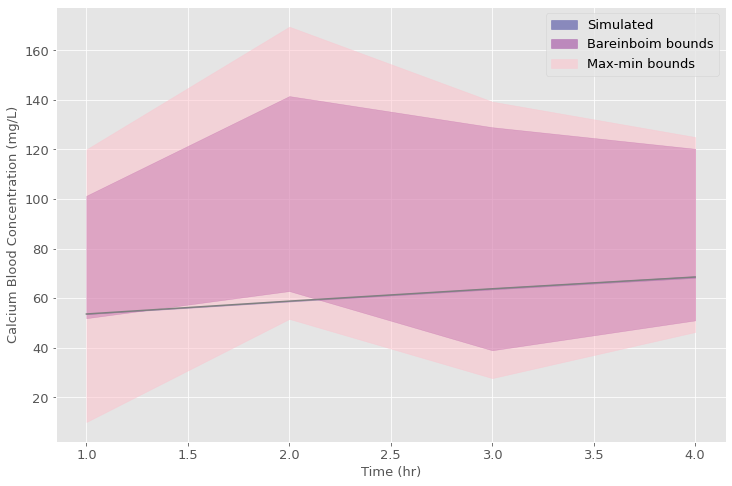

In [71]:
plot_bounds_bootstrap(col_name, 0, 2, [3,3,3,3], [3, 3, 3, 3])

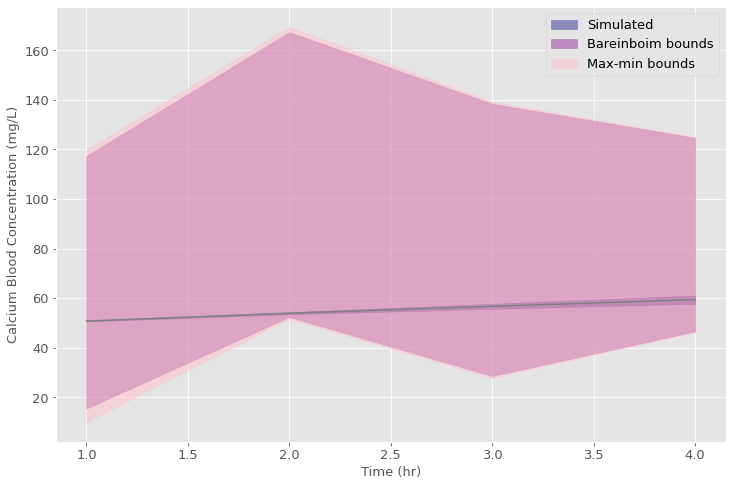

In [73]:
plot_bounds_bootstrap(col_name, 0, 2, [2.0, 2.0, 2.0, 2.0], [3, 3, 3, 3])

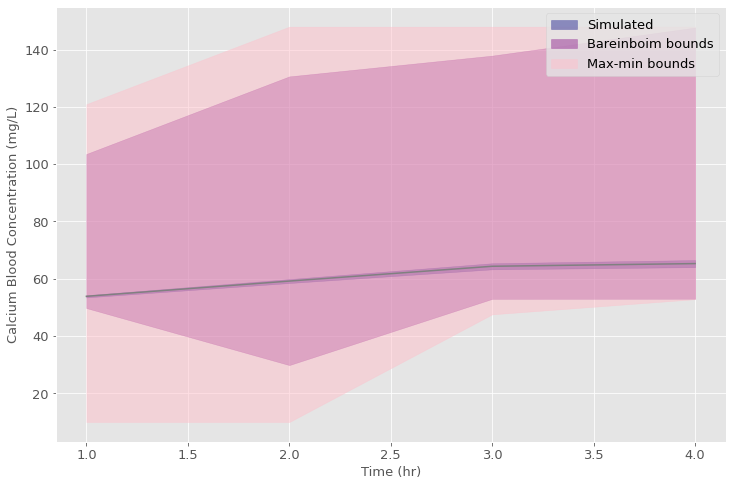

In [75]:
plot_bounds_bootstrap(col_name, 1, 4, [3.0, 3.0, 3.0, 2.0], [3, 3, 3, 3])

## Visualise p-values

100%|██████████| 15/15 [00:00<00:00, 200.59it/s]


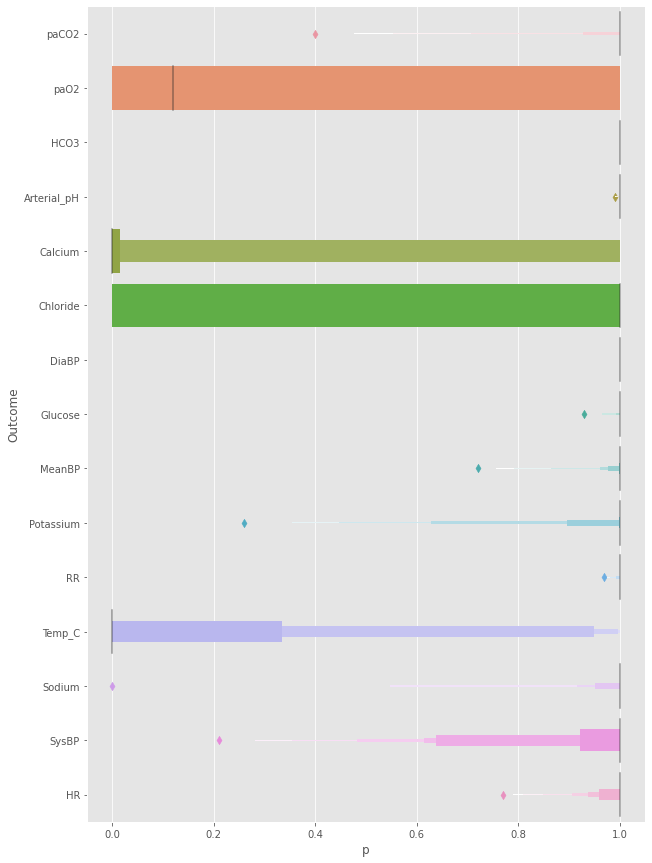

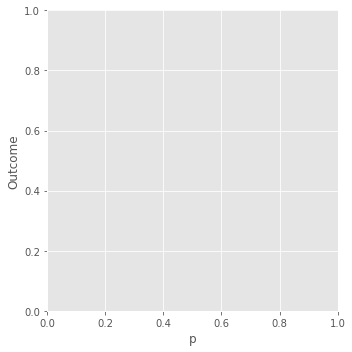

In [76]:
import seaborn as sns

x_columns = ['paCO2', 'paO2', 'HCO3', 'Arterial_pH', 'Calcium', 'Chloride', 'DiaBP', 'Glucose', 'MeanBP', 'Potassium', 'RR', 'Temp_C', 'Sodium', 'SysBP', 'HR']
combined_p_values = pd.DataFrame()
for col_name in tqdm(x_columns):
    p_values = pd.read_csv(f"{hyp_test_dir}/p_values_{col_name}.csv", converters={'actions': eval, col_name: eval})
    p_values.rename(columns={col_name: 'col_v'}, inplace=True)
    p_values['Outcome'] = col_name
    combined_p_values = combined_p_values.append(p_values, ignore_index=True)

fig, axs = plt.subplots(1, figsize=(10,15))    
sns.catplot(x='p',y='Outcome', data=combined_p_values, ax=axs, kind="boxen")

In [79]:
def rej_hyps_age_group(col, gender, age):
    rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col_name}.csv", converters={'actions': eval, 'x_t': eval})
    trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions.csv", converters={'actions': eval, 'x_t': eval})
    state_actions = trajec_actions[['gender', 'age', 'actions', 'x_t']].copy()
    state_actions.loc[:,'a'] = state_actions['actions'].apply(tuple)
    state_actions.loc[:,'s'] = state_actions['x_t'].apply(tuple)
    state_actions = state_actions.groupby(by=['gender', 'age', 'a', 's']).filter(lambda x: len(x) >= 10).drop_duplicates(['gender', 'age', 'a', 's'])
    total_hyp = ((state_actions['age']==age)&(state_actions['gender']==gender)).sum()
    rej_hyps_num = ((rej_hyps['age']==age)&(rej_hyps['gender']==gender)).sum()
    return rej_hyps_num/total_hyp*100

In [80]:
rej_hyps_age_group('HR', 0, 4)

0.0

In [81]:
ages = []
for i in range(1, 4):
    age_min = str(int(MIMICtable.loc[MIMICtable['age']==i, 'age_raw'].min()/365))
    age_max = str(int(MIMICtable.loc[MIMICtable['age']==i+1, 'age_raw'].min()/365))
    ages.append(f'{age_min}-{age_max}')
ages.append(f'>{age_max}')

In [84]:
col_name = 'Calcium'
rej_hyps_age = pd.DataFrame()
gend = ['male', 'female']
for gender in [0,1]:
    for age in [1,2,3,4]:
        rh = rej_hyps_age_group(col_name, gender, age)
        rej_hyps_age = rej_hyps_age.append({'gender': gend[gender], 'age': ages[age-1], 'rej_hyps': rh}, ignore_index=True)

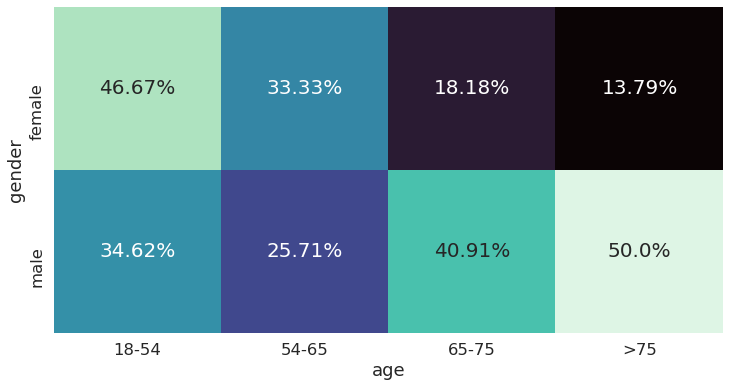

In [85]:
import seaborn as sns
fig, axs = plt.subplots(1, figsize=(12,6))
rej_hyps_age_pivot = rej_hyps_age.pivot_table(index="gender", columns="age", values="rej_hyps", aggfunc=np.min)
sns.set(font_scale=1.5)
labels = np.round(rej_hyps_age_pivot.values,2).astype(str)
for i in range(len(labels)):
    for j in range(len(labels[0])):
        labels[i][j] += '%'
sns.heatmap(rej_hyps_age_pivot, vmax=rej_hyps_age_pivot.values.max(), vmin=rej_hyps_age_pivot.values.min(), annot=labels, fmt='', cmap='mako', ax=axs, annot_kws={"fontsize":20}, cbar=False)

# Divide by severity

In [236]:
import numpy as np
def generate_dataframe_by_severity():
    df = pd.DataFrame()
    for col_name in tqdm(column_names_unit):
        rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col_name}.csv", converters={'actions': eval, col_name: eval})
        trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
#         print("Rej hyps", len(rej_hyps))
#         print("Trajec actions", len(trajec_actions))
        state_actions_unique = trajec_actions.copy()
        state_actions_unique.loc[:,'a'] = trajec_actions['actions'].apply(tuple)
        state_actions_unique.loc[:,'s'] = trajec_actions[col_name].apply(tuple)
        state_actions_unique = state_actions_unique.drop_duplicates(['gender', 'age', 'a', 's'])
        for index, row in state_actions_unique.iterrows():
            if np.median(row['s']) <= 1:
                state_actions_unique.loc[index, 'Outcome severity'] = 'extremely low'
            elif np.median(row['s']) <= 2:
                state_actions_unique.loc[index, 'Outcome severity'] = 'low'
            elif np.median(row['s']) <= 3:
                state_actions_unique.loc[index, 'Outcome severity'] = 'medium'
            elif np.median(row['s']) <= 4:
                state_actions_unique.loc[index, 'Outcome severity'] = 'high'
            elif np.median(row['s']) <= 5:
                state_actions_unique.loc[index, 'Outcome severity'] = 'very high'
                
        for index, row in rej_hyps.iterrows():
#             print(np.median(row[col_name]))
            if np.median(row[col_name]) <= 1:
                rej_hyps.loc[index, 'Outcome severity'] = 'extremely low'
            elif np.median(row[col_name]) <= 2:
                rej_hyps.loc[index, 'Outcome severity'] = 'low'
            elif np.median(row[col_name]) <= 3:
                rej_hyps.loc[index, 'Outcome severity'] = 'medium'
            elif np.median(row[col_name]) <= 4:
                rej_hyps.loc[index, 'Outcome severity'] = 'high'
            elif np.median(row[col_name]) <= 5:
                rej_hyps.loc[index, 'Outcome severity'] = 'very high'
        for severity in ['extremely low', 'low', 'medium', 'high', 'very high']:
            if len(rej_hyps) > 0:
                df = df.append({'Outcome': col_name, 'Outcome severity': severity, '# rejected hypotheses': (rej_hyps['Outcome severity']==severity).sum(), 'Total # hypotheses': (state_actions_unique['Outcome severity']==severity).sum(), '% rejected': (rej_hyps['Outcome severity']==severity).sum()/(state_actions_unique['Outcome severity']==severity).sum()*100}, ignore_index=True)
            else:
                df = df.append({'Outcome': col_name, 'Outcome severity': severity, '# rejected hypotheses': 0, 'Total # hypotheses': (state_actions_unique['Outcome severity']==severity).sum(), '% rejected': 0}, ignore_index=True)
    return df

In [237]:
df = generate_dataframe_by_severity()

100%|██████████| 16/16 [00:28<00:00,  1.80s/it]


In [238]:
df = df.pivot_table(index=["Outcome"], columns="Outcome severity", values="% rejected", aggfunc=np.max)
df.style.format('{:.1f}').background_gradient(cmap ='viridis')

Outcome severity,extremely low,high,low,medium,very high
Outcome,,,,,
Albumin,0.0,1.1,0.0,0.0,0.0
Arterial_lactate,0.0,0.0,0.0,0.0,0.0
Arterial_pH,0.0,0.0,0.0,0.0,0.0
Calcium,2.6,0.0,0.0,0.0,0.0
Chloride,0.0,0.0,0.0,0.0,0.0
Creatinine,0.0,0.8,0.0,0.0,0.1
DiaBP,0.0,0.0,0.0,0.0,0.0
Glucose,0.0,0.0,0.0,0.0,0.1
HR,0.5,0.2,0.6,0.5,0.3


# Only hypotheses with $n_{obs}\geq 10$ 

In [240]:
state_actions = trajec_actions[['gender', 'age', 'actions', col_name]].copy()
state_actions.loc[:,'a'] = state_actions['actions'].apply(tuple)
state_actions.loc[:,'s'] = state_actions[col_name].apply(tuple)
state_actions = state_actions.drop_duplicates(['gender', 'age', 'a', 's'])

In [241]:
state_actions

,gender,age,actions,HR,a,s
0,0.0,1.0,"[1.0, 2.0, 3.0, 3.0]","[2.0, 2.0, 2.0, 2.0]","(1.0, 2.0, 3.0, 3.0)","(2.0, 2.0, 2.0, 2.0)"
1,0.0,4.0,"[4.0, 5.0, 4.0, 3.0]","[2.0, 1.0, 1.0, 1.0]","(4.0, 5.0, 4.0, 3.0)","(2.0, 1.0, 1.0, 1.0)"
2,1.0,4.0,"[6.0, 7.0, 7.0, 8.0]","[3.0, 2.0, 2.0, 2.0]","(6.0, 7.0, 7.0, 8.0)","(3.0, 2.0, 2.0, 2.0)"
3,0.0,2.0,"[1.0, 1.0, 1.0, 1.0]","[4.0, 4.0, 4.0, 4.0]","(1.0, 1.0, 1.0, 1.0)","(4.0, 4.0, 4.0, 4.0)"
4,0.0,2.0,"[3.0, 3.0, 3.0, 3.0]","[2.0, 3.0, 2.0, 2.0]","(3.0, 3.0, 3.0, 3.0)","(2.0, 3.0, 2.0, 2.0)"
...,...,...,...,...,...,...
6171,0.0,1.0,"[1.0, 1.0, 1.0, 1.0]","[1.0, 4.0, 5.0, 2.0]","(1.0, 1.0, 1.0, 1.0)","(1.0, 4.0, 5.0, 2.0)"
6172,1.0,4.0,"[2.0, 2.0, 2.0, 2.0]","[3.0, 3.0, 2.0, 2.0]","(2.0, 2.0, 2.0, 2.0)","(3.0, 3.0, 2.0, 2.0)"
6174,0.0,4.0,"[1.0, 1.0, 5.0, 5.0]","[3.0, 3.0, 3.0, 3.0]","(1.0, 1.0, 5.0, 5.0)","(3.0, 3.0, 3.0, 3.0)"
6175,1.0,2.0,"[1.0, 1.0, 1.0, 1.0]","[1.0, 4.0, 5.0, 4.0]","(1.0, 1.0, 1.0, 1.0)","(1.0, 4.0, 5.0, 4.0)"


In [242]:
def filtered_rejected_hypotheses():
    df = pd.DataFrame()
    all_rej_hyps = pd.DataFrame()
    all_hyps = pd.DataFrame()
    for col_name in tqdm(column_names_unit):
        rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col_name}.csv", converters={'actions': eval, col_name: eval})
        trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
        sim_trajec_actions = pd.read_csv(f"{hyp_test_dir}/sim_trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
        if len(rej_hyps)>0:
#             rej_hyps = rej_hyps[(rej_hyps['n_real']>=10)&(rej_hyps['n_sim']>=10)]
            rej_hyps = rej_hyps[(rej_hyps['n_real']>=10)]
            state_actions = trajec_actions[['gender', 'age', 'actions', col_name]].copy()
            state_actions.loc[:,'a'] = state_actions['actions'].apply(tuple)
            state_actions.loc[:,'s'] = state_actions[col_name].apply(tuple)
            trajec_actions.loc[:,'a'] = trajec_actions['actions'].apply(tuple)
            trajec_actions.loc[:,'s'] = trajec_actions[col_name].apply(tuple)
            sim_trajec_actions.loc[:,'a'] = sim_trajec_actions['actions'].apply(tuple)
            sim_trajec_actions.loc[:,'s'] = sim_trajec_actions[col_name].apply(tuple)
            state_actions = state_actions.drop_duplicates(['gender', 'age', 'a', 's'])
            for index, row in state_actions.iterrows():
                state_actions.loc[index, 'n_real'] = ((trajec_actions['gender']==row['gender']) & (trajec_actions['age']==row['age']) & (trajec_actions['a']==row['a']) & (trajec_actions['s']==row['s'])).sum()
                state_actions.loc[index, 'n_sim'] = ((sim_trajec_actions['gender']==row['gender']) & (sim_trajec_actions['age']==row['age']) & (sim_trajec_actions['a']==row['a']) & (sim_trajec_actions['s']==row['s'])).sum()
#             state_actions = state_actions[(state_actions['n_real']>=10)&(state_actions['n_sim']>=10)]
            state_actions = state_actions[(state_actions['n_real']>=10)]
        df = df.append({'Outcome Y': col_name, '# rejected hypotheses': len(rej_hyps), 'Total # hypotheses': len(state_actions)}, ignore_index=True)
        rej_hyps['col_name'] = col_name
        state_actions['col_name'] = col_name
        all_rej_hyps = all_rej_hyps.append(rej_hyps, ignore_index=True)
        all_hyps = all_hyps.append(state_actions, ignore_index=True)
    return df, all_rej_hyps, all_hyps

In [243]:
df, all_rej_hyps, all_hyps = filtered_rejected_hypotheses()

100%|██████████| 16/16 [01:51<00:00,  6.96s/it]


In [244]:
df.head()

,# rejected hypotheses,Outcome Y,Total # hypotheses
0,8.0,Albumin,38.0
1,0.0,Arterial_pH,38.0
2,0.0,Arterial_lactate,38.0
3,1.0,Calcium,31.0
4,0.0,Chloride,31.0


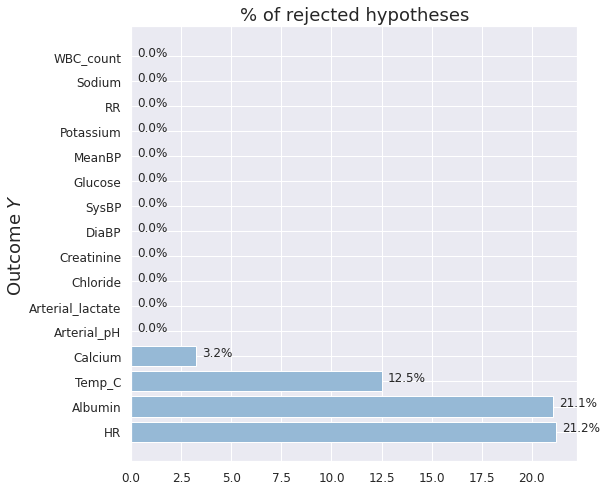

In [245]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
df['% rejected'] = df['# rejected hypotheses']/df['Total # hypotheses']*100
df.sort_values('% rejected', ascending=False, inplace=True)
ax.barh(df['Outcome Y'],df['% rejected'],  color='#96b9d6')
y = df['% rejected']
for i, v in enumerate(y):
    ax.text(v + 0.3, i, "{:.1f}%".format(v), fontsize=12)

plt.title('% of rejected hypotheses')
plt.ylabel('Outcome $Y$')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
plt.style.use('ggplot')
plt.show()

In [246]:
def rej_hyps_age_group(col, gender, age):
    state_actions = all_hyps[all_hyps['col_name']==col]
    rej_hyps = all_rej_hyps[all_rej_hyps['col_name']==col]
    total_hyp = ((state_actions['age']==age)&(state_actions['gender']==gender)).sum()
    rej_hyps_num = ((rej_hyps['age']==age)&(rej_hyps['gender']==gender)).sum()
    if total_hyp > 0:
        return rej_hyps_num/total_hyp*100
    return 0

In [247]:
def plot_heatmap(col_name):
    rej_hyps_age = pd.DataFrame()
    gend = ['male', 'female']
    for gender in [0,1]:
        for age in [1,2,3,4]:
            rh = rej_hyps_age_group(col_name, gender, age)
            rej_hyps_age = rej_hyps_age.append({'gender': gend[gender], 'age': ages[age-1], 'rej_hyps': rh}, ignore_index=True)
    fig, axs = plt.subplots(1, figsize=(12,6))
    rej_hyps_age_pivot = rej_hyps_age.pivot_table(index="gender", columns="age", values="rej_hyps", aggfunc=np.min)
    sns.set(font_scale=1.5)
    labels = np.round(rej_hyps_age_pivot.values,2).astype(str)
    for i in range(len(labels)):
        for j in range(len(labels[0])):
            labels[i][j] += '%'
    sns.heatmap(rej_hyps_age_pivot, vmax=rej_hyps_age_pivot.values.max(), vmin=rej_hyps_age_pivot.values.min(), annot=labels, fmt='', cmap='mako', ax=axs, annot_kws={"fontsize":20}, cbar=False)

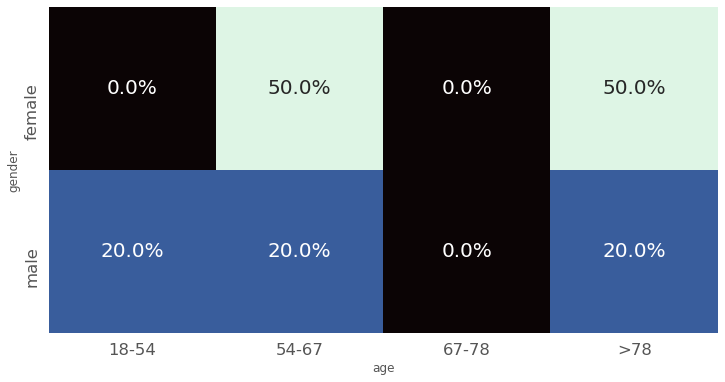

In [248]:
plot_heatmap('HR')

In [249]:
combined_p_values.head()

,Unnamed: 0,col_v,actions,age,gender,p,Outcome
0,0,"[4.0, 4.0, 4.0, 4.0]","[1.0, 1.0, 1.0, 1.0]",1.0,1.0,0.0,Albumin
1,1,"[4.0, 4.0, 4.0, 4.0]","[1.0, 1.0, 1.0, 1.0]",3.0,0.0,0.0,Albumin
2,2,"[4.0, 4.0, 4.0, 4.0]","[1.0, 1.0, 1.0, 1.0]",4.0,0.0,0.0,Albumin
3,3,"[4.0, 4.0, 4.0, 4.0]","[1.0, 1.0, 1.0, 1.0]",2.0,0.0,0.0,Albumin
4,4,"[4.0, 4.0, 4.0, 4.0]","[1.0, 1.0, 1.0, 2.0]",3.0,0.0,0.0,Albumin


In [212]:
def generate_violin_plots(hyp_test_dir):
    combined_df = pd.DataFrame()
    for col_name in tqdm(column_names_unit):
        if col_name in all_hyps:
            rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col_name}.csv", converters={'actions': eval, col_name: eval})
            trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
            sim_trajec_actions = pd.read_csv(f"{hyp_test_dir}/sim_trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})

            rej_hyps_filtered = all_rej_hyps[all_rej_hyps['col_name']==col_name].copy()
            all_hyps_filtered = all_hyps[all_hyps['col_name']==col_name].copy()
            all_hyps_filtered = all_hyps_filtered[[col_name, 'gender', 'age', 'actions']].copy()
            all_hyps_filtered['gamma'] = all_hyps_filtered.apply(lambda x: compute_probs(trajec_actions, col_name, x[0], x[1], x[2], x[3])[-1], axis=1)            

            non_rej_hyps = pd.DataFrame()
            for index, row in all_hyps_filtered.iterrows():
                 if ((rej_hyps_filtered['gender']==row['gender']) & (rej_hyps_filtered['age']==row['age']) & (rej_hyps_filtered[col_name].apply(tuple)==tuple(row[col_name])) & (rej_hyps_filtered['actions'].apply(tuple)==tuple(row['actions']))).sum() == 0:
                        non_rej_hyps = non_rej_hyps.append(row, ignore_index=True)

            non_rej_hyps['Outcome'] = f'{col_name}'+'$_{a}$'
            if len(rej_hyps_filtered) > 0:
                rej_hyps_filtered = rej_hyps_filtered[[col_name, 'gender', 'age', 'actions']]
                rej_hyps_filtered['gamma'] = rej_hyps_filtered.apply(lambda x: compute_probs(trajec_actions, col_name, x[0], x[1], x[2], x[3])[-1], axis=1)
                rej_hyps_filtered['Outcome'] = f'{col_name}' + '$_{r}$'
                combined = non_rej_hyps[['Outcome', 'gamma']].merge(rej_hyps_filtered[['Outcome', 'gamma']], left_on=['Outcome', 'gamma'], right_on=['Outcome', 'gamma'], how='outer')
            else:
                combined = non_rej_hyps[['Outcome', 'gamma']]
            combined_df = combined_df.append(combined, ignore_index=True)
    return combined_df

In [213]:
combined_df = generate_violin_plots(hyp_test_dir)

100%|██████████| 16/16 [00:05<00:00,  3.09it/s]


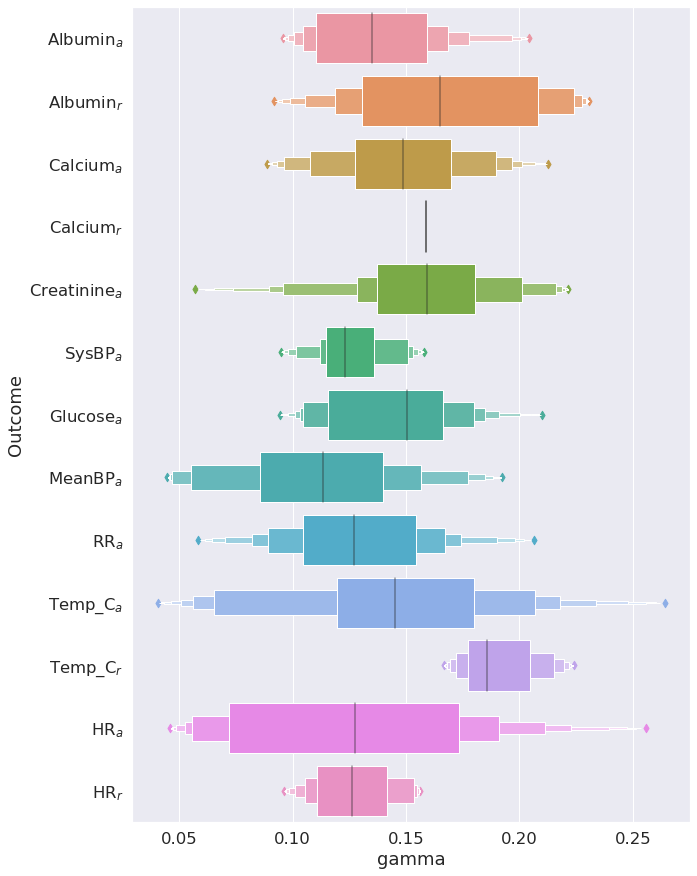

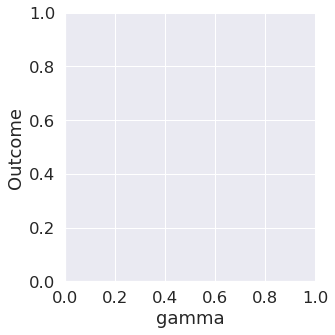

In [221]:
fig, axs = plt.subplots(1, figsize=(10,15))
sns.catplot(x='gamma',y='Outcome', data=combined_df, ax=axs, kind="boxen")

In [250]:
def plot_combined_heatmap():
    rej_hyps_all = pd.DataFrame()
#     fig, axs = plt.subplots(len(column_names_dict),1, figsize=(12,36))
    columns = list(column_names_dict.keys())
    for index in range(len(column_names_dict)):
        col_name = columns[index]
        rej_hyps_age = pd.DataFrame()
        gend = ['M', 'F']
        for gender in [0,1]:
            for age in [1,2,3,4]:
                rh = rej_hyps_age_group(col_name, gender, age)
                rej_hyps_age = rej_hyps_age.append({'gender': gend[gender], 'age': ages[age-1], 'rej_hyps': rh}, ignore_index=True)
        rej_hyps_age['Outcome'] = col_name
        rej_hyps_all = rej_hyps_all.append(rej_hyps_age, ignore_index=True)
        rej_hyps_age_pivot = rej_hyps_age.pivot_table(index="gender", columns="age", values="rej_hyps", aggfunc=np.min)
        sns.set(font_scale=1.5)
        labels = np.round(rej_hyps_age_pivot.values,2).astype(str)
        for i in range(len(labels)):
            for j in range(len(labels[0])):
                labels[i][j] += '%'
#         sns.heatmap(rej_hyps_age_pivot, vmax=rej_hyps_age_pivot.values.max(), vmin=rej_hyps_age_pivot.values.min(), annot=labels, fmt='', cmap='mako', ax=axs[index], annot_kws={"fontsize":20}, cbar=False)
    return rej_hyps_all

In [251]:
# pd.options.display.float_format = "{:,.2f}".format
# df = df.round(2)
df = plot_combined_heatmap()
df = df.pivot_table(index=["Outcome","gender"], columns="age", values="rej_hyps", aggfunc=np.min)
df.style.format('{:.0f}').background_gradient(cmap ='viridis')

In [252]:
# df.style.format('{:.0f}')
df = df.loc[df.sum(axis=1)>0, :]
df.style.format('{:.0f}').background_gradient(cmap ='viridis')

# Divide by severity

In [253]:
import numpy as np
def generate_dataframe_by_severity():
    df = pd.DataFrame()
    for col_name in tqdm(column_names_unit):
        rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_{col_name}.csv", converters={'actions': eval, col_name: eval})
        trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
        sim_trajec_actions = pd.read_csv(f"{hyp_test_dir}/sim_trajec_actions_{col_name}.csv", converters={'actions': eval, col_name: eval})
        if len(rej_hyps)>0:
#             rej_hyps = rej_hyps[(rej_hyps['n_real']>=10)&(rej_hyps['n_sim']>=10)]
            rej_hyps = rej_hyps[(rej_hyps['n_real']>=10)]
            state_actions = trajec_actions[['gender', 'age', 'actions', col_name]].copy()
            state_actions.loc[:,'a'] = state_actions['actions'].apply(tuple)
            state_actions.loc[:,'s'] = state_actions[col_name].apply(tuple)
            trajec_actions.loc[:,'a'] = trajec_actions['actions'].apply(tuple)
            trajec_actions.loc[:,'s'] = trajec_actions[col_name].apply(tuple)
            sim_trajec_actions.loc[:,'a'] = sim_trajec_actions['actions'].apply(tuple)
            sim_trajec_actions.loc[:,'s'] = sim_trajec_actions[col_name].apply(tuple)
            state_actions = state_actions.drop_duplicates(['gender', 'age', 'a', 's'])
            for index, row in state_actions.iterrows():
                state_actions.loc[index, 'n_real'] = ((trajec_actions['gender']==row['gender']) & (trajec_actions['age']==row['age']) & (trajec_actions['a']==row['a']) & (trajec_actions['s']==row['s'])).sum()
                state_actions.loc[index, 'n_sim'] = ((sim_trajec_actions['gender']==row['gender']) & (sim_trajec_actions['age']==row['age']) & (sim_trajec_actions['a']==row['a']) & (sim_trajec_actions['s']==row['s'])).sum()
#             state_actions = state_actions[(state_actions['n_real']>=10)&(state_actions['n_sim']>=10)]
            state_actions = state_actions[(state_actions['n_real']>=10)]

        for index, row in state_actions.iterrows():
            if np.median(row['s']) <= 1:
                state_actions.loc[index, 'Outcome severity'] = 'extremely low'
            elif np.median(row['s']) <= 2:
                state_actions.loc[index, 'Outcome severity'] = 'low'
            elif np.median(row['s']) <= 3:
                state_actions.loc[index, 'Outcome severity'] = 'medium'
            elif np.median(row['s']) <= 4:
                state_actions.loc[index, 'Outcome severity'] = 'high'
            elif np.median(row['s']) <= 5:
                state_actions.loc[index, 'Outcome severity'] = 'very high'
                
        for index, row in rej_hyps.iterrows():
#             print(np.median(row[col_name]))
            if np.median(row[col_name]) <= 1:
                rej_hyps.loc[index, 'Outcome severity'] = 'extremely low'
            elif np.median(row[col_name]) <= 2:
                rej_hyps.loc[index, 'Outcome severity'] = 'low'
            elif np.median(row[col_name]) <= 3:
                rej_hyps.loc[index, 'Outcome severity'] = 'medium'
            elif np.median(row[col_name]) <= 4:
                rej_hyps.loc[index, 'Outcome severity'] = 'high'
            elif np.median(row[col_name]) <= 5:
                rej_hyps.loc[index, 'Outcome severity'] = 'very high'
        for severity in ['extremely low', 'low', 'medium', 'high', 'very high']:
            if len(rej_hyps) > 0:
                df = df.append({'Outcome': col_name, 'Outcome severity': severity, '# rejected hypotheses': (rej_hyps['Outcome severity']==severity).sum(), 'Total # hypotheses': (state_actions['Outcome severity']==severity).sum(), '% rejected': (rej_hyps['Outcome severity']==severity).sum()/(state_actions['Outcome severity']==severity).sum()*100}, ignore_index=True)
            else:
                df = df.append({'Outcome': col_name, 'Outcome severity': severity, '# rejected hypotheses': 0, 'Total # hypotheses': (state_actions['Outcome severity']==severity).sum(), '% rejected': 0}, ignore_index=True)
    return df

In [254]:
df = generate_dataframe_by_severity()

100%|██████████| 16/16 [01:49<00:00,  6.86s/it]


In [255]:
df = df.pivot_table(index=["Outcome"], columns="Outcome severity", values="% rejected", aggfunc=np.max)
df.style.format('{:.1f}').background_gradient(cmap ='viridis')

Outcome severity,extremely low,high,low,medium,very high
Outcome,,,,,
Albumin,0.0,100.0,0.0,0.0,0.0
Arterial_lactate,0.0,0.0,0.0,0.0,0.0
Arterial_pH,0.0,0.0,0.0,0.0,0.0
Calcium,33.3,0.0,0.0,0.0,0.0
Chloride,0.0,0.0,0.0,0.0,0.0
Creatinine,0.0,0.0,0.0,0.0,0.0
DiaBP,0.0,0.0,0.0,0.0,0.0
Glucose,0.0,0.0,0.0,0.0,0.0
HR,0.0,0.0,75.0,66.7,0.0


# Dividing by SOFA scores

In [82]:
def rej_hyps_by_sofa(col, gender, age):
    sofa_df = pd.DataFrame()
    sofa_vals = ['x<=6', '6<x<=12', '12<x<=18', 'x>18']
    for sofa in range(4):
#         hyp_test_dir = "/data/localhost/taufiq/hyp-test-dir-pulse-trajecs-sofa"
        hyp_test_dir = "/data/localhost/taufiq/bootstrap-updated/pulse_trajecs_sofa"
        rej_hyps = pd.read_csv(f"{hyp_test_dir}/rej_hyps_sofabin_{sofa}_{col}.csv", converters={'actions': eval, col_name: eval})
        trajec_actions = pd.read_csv(f"{hyp_test_dir}/trajec_actions_sofabin_{sofa}_{col}.csv", converters={'actions': eval, col_name: eval})
        sim_trajec_actions = pd.read_csv(f"{hyp_test_dir}/sim_trajec_actions_sofabin_{sofa}_{col}.csv", converters={'actions': eval, col_name: eval})
        trajec_actions.loc[:,'s'] = trajec_actions[col].apply(tuple)
        trajec_actions.loc[:,'a'] = trajec_actions['actions'].apply(tuple)
        trajec_actions = trajec_actions[(trajec_actions['gender']==gender) & (trajec_actions['age']==age)]
        sim_trajec_actions.loc[:,'s'] = sim_trajec_actions[col].apply(tuple)
        sim_trajec_actions.loc[:,'a'] = sim_trajec_actions['actions'].apply(tuple)
        sim_trajec_actions = sim_trajec_actions[(sim_trajec_actions['gender']==gender) & (sim_trajec_actions['age']==age)]
        for index, row in trajec_actions.iterrows():
                trajec_actions.loc[index, 'n_real'] = ((trajec_actions['gender']==row['gender']) & (trajec_actions['age']==row['age']) & (trajec_actions['a']==row['a']) & (trajec_actions['s']==row['s'])).sum()
                trajec_actions.loc[index, 'n_sim'] = ((sim_trajec_actions['gender']==row['gender']) & (sim_trajec_actions['age']==row['age']) & (sim_trajec_actions['a']==row['a']) & (sim_trajec_actions['s']==row['s'])).sum()
        trajec_actions = trajec_actions.drop_duplicates(['gender', 'age', 'a', 's'])
        sim_trajec_actions = sim_trajec_actions.drop_duplicates(['gender', 'age', 'a', 's'])
        if len(trajec_actions) > 0:
            trajec_actions = trajec_actions[(trajec_actions['n_real']>=5)]
#             trajec_actions = trajec_actions[(trajec_actions['n_real']>=10)&(trajec_actions['n_sim']>=10)]
        if len(rej_hyps)>0:
#             rej_hyps = rej_hyps[(rej_hyps['n_real']>=10) & (rej_hyps['n_sim']>=10)]
            rej_hyps = rej_hyps[(rej_hyps['n_real']>=5)]
            rej_hyps = rej_hyps[(rej_hyps['gender']==gender) & (rej_hyps['age']==age)]
        if len(trajec_actions)==0:
            sofa_df = sofa_df.append({'SOFA': sofa_vals[sofa], '# rejected hypotheses': len(rej_hyps), 'Total # hypotheses': len(trajec_actions), '% rejected': float('nan')}, ignore_index=True)
        else:
            sofa_df = sofa_df.append({'SOFA': sofa_vals[sofa], '# rejected hypotheses': len(rej_hyps), 'Total # hypotheses': len(trajec_actions), '% rejected': len(rej_hyps)/len(trajec_actions)*100}, ignore_index=True)
    return sofa_df

In [83]:
col = "Sodium"
rej_hyps_by_sofa(col, 0,4)

,# rejected hypotheses,% rejected,SOFA,Total # hypotheses
0,1.0,14.285714,x<=6,7.0
1,1.0,33.333333,6<x<=12,3.0
2,0.0,NaN,12<x<=18,0.0
3,0.0,NaN,x>18,0.0


In [84]:
hyp_test_dir = "/data/localhost/taufiq/bootstrap-updated/pulse_trajecs_sofa"
nums = pd.read_csv(f"{hyp_test_dir}/rej_hyp_nums.csv")
nums.loc[:, '% rejected'] = nums['# rejected hypotheses']/nums['Total # hypotheses']*100
nums = nums.pivot_table(index=["Outcome Y"], columns="SOFA bin", values="% rejected", aggfunc=np.max)
# nums.style.format('{:.1f}').background_gradient(cmap ='viridis')
nums.style.format('{:.1f}').background_gradient(cmap ='viridis')

SOFA bin,0,1,2,3
Outcome Y,,,,
Albumin,0.0,0.2,0.0,0.0
Arterial_lactate,1.4,0.9,0.0,0.0
Arterial_pH,0.3,0.1,0.4,0.0
Calcium,6.8,3.3,0.4,0.0
Chloride,1.8,1.1,0.4,0.0
Creatinine,0.3,0.4,0.0,0.0
DiaBP,0.0,0.0,0.0,0.0
Glucose,0.0,0.1,0.0,0.0
HCO3,0.1,0.0,0.4,0.0


In [85]:
hyp_test_dir = "/data/localhost/taufiq/bootstrap-updated/pulse_trajecs_sofa"
nums = pd.read_csv(f"{hyp_test_dir}/rej_hyp_nums.csv")
nums[nums['SOFA bin'] == 0]

,Outcome Y,# rejected hypotheses,Total # hypotheses,SOFA bin
114,WBC_count,41,3102,0
115,Sodium,42,2913,0
116,DiaBP,1,3229,0
117,Creatinine,7,3056,0
118,SysBP,5,3206,0
119,RR,1,3255,0
120,Arterial_lactate,40,2955,0
121,Chloride,53,2933,0
122,Sodium,42,2913,0
123,Glucose,1,3042,0


# Average doses

In [86]:
def average_doses(actions):
    iv_avg = 0
    vc_avg = 0
    for a in actions:
        iv_avg += uniqueValueDoses.loc[a-1, 'IV']
        vc_avg += uniqueValueDoses.loc[a-1, 'VC']
    return iv_avg/len(actions), vc_avg/len(actions)

In [87]:
def rej_hyps_age_group_plot_doses(col, gender, age):
    
    for index, row in all_hyps.iterrows():
        all_hyps.at[index,'Avg IV'], all_hyps.at[index, 'Avg VC'] = average_doses(np.array(row['actions']))
#     rej_hyps = all_rej_hyps[all_rej_hyps['col_name']==col]
#     total_hyp = ((state_actions['age']==age)&(state_actions['gender']==gender)).sum()
#     rej_hyps_num = ((rej_hyps['age']==age)&(rej_hyps['gender']==gender)).sum()
    
    iv_nonzero = all_hyps.loc[all_hyps['Avg IV']>0, 'Avg IV']    
    iv_ranked = rankdata(iv_nonzero)/len(iv_nonzero) # excludes zero fluid (will be action 1)
    iv_f = np.floor((iv_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
    iv = np.ones(len(all_hyps)) # array of ones, by default
    iv[all_hyps['Avg IV']>0] = iv_f + 1 # where more than zero fluid given: save actual action
    all_hyps['IV'] = iv
    
    vc_nonzero = all_hyps.loc[all_hyps['Avg VC']>0, 'Avg VC']    
    vc_ranked = rankdata(vc_nonzero)/len(vc_nonzero) # excludes zero fluid (will be action 1)
    vc_f = np.floor((vc_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
    vc = np.ones(len(all_hyps)) # array of ones, by default
    vc[all_hyps['Avg VC']>0] = vc_f + 1 # where more than zero fluid given: save actual action
    all_hyps['VC'] = vc
    return all_hyps
    
    ivs = []
    for i in range(1, 4):
        iv_min = str(int(all_hyps.loc[all_hyps['IV']==i, 'Avg IV'].min()))
        iv_max = str(int(all_hyps.loc[all_hyps['IV']==i+1, 'Avg IV'].min()))
        ivs.append(f'{iv_min}-{iv_max}')
    ivs.append(f'>{iv_max}')
    
    vcs = []
    for i in range(1, 4):
        vc_min = str(int(all_hyps.loc[all_hyps['VC']==i, 'Avg VC'].min()))
        vc_max = str(int(all_hyps.loc[all_hyps['VC']==i+1, 'Avg VC'].min()))
        vcs.append(f'{vc_min}-{vc_max}')
    vcs.append(f'>{vc_max}')
    
    state_actions = all_hyps[all_hyps['col_name']==col]

    for index, row in state_actions.iterrows():
        state_actions.at[index, 'IV_avg_dose'] = ivs[row['IV']-1]
        state_actions.at[index, 'VC_avg_dose'] = vcs[row['VC']-1]   
    return state_actions
    
#     if total_hyp > 0:
#         return rej_hyps_num/total_hyp*100
#     return 0

In [88]:
df = rej_hyps_age_group_plot_doses('Temp_C', 1, 3)
# len(df)
# df = df[df['col_name']=='Temp_C']
# df[['']].pivot_table()

In [89]:
state_actions = all_hyps[all_hyps['col_name']=='Temp_C']

In [90]:
average_doses(np.array(state_actions['actions'].values[0])*2)

(10.0, 0.0)

In [91]:
actionbloc.head()

,action_bloc
0,1
1,2
2,3
3,3
4,3


In [92]:
med.head()

,IV,VC
0,1,1
1,2,1
2,3,1
3,3,1
4,3,1


In [93]:
uniqueValues.head()

,IV,VC
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
